In [21]:
import numpy as np
from sklearn.model_selection import train_test_split

from processing.preprocessing import BCIDataProcessor

recording_path = '../recordings/recording_relax1.raw.fif'
window_size = 2
window_overlap = 0
processor = BCIDataProcessor(recording_path, l_freq=10, h_freq=20, window_size=window_size,
                             window_overlap=window_overlap)
data = processor.process(psds=True, nfft=500)
# Only select left_hand and right_hand
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

{'relax': array([[[1.66704648e-12, 1.08389355e-12, 7.15323044e-13, ...,
          9.46167113e-13, 2.02581140e-12, 2.85392254e-12],
         [1.62902946e-12, 3.22039724e-13, 2.79507277e-12, ...,
          1.60223577e-12, 3.39298738e-12, 6.50331988e-12],
         [3.95631197e-12, 4.83227756e-12, 1.10661424e-12, ...,
          1.18950801e-12, 1.36583578e-12, 2.52136913e-12],
         ...,
         [7.90510925e-13, 3.43462466e-15, 1.93360399e-12, ...,
          1.63760524e-12, 2.24052466e-12, 5.06951856e-12],
         [2.52617933e-12, 2.89338116e-12, 1.23096821e-13, ...,
          2.45159668e-12, 1.24796514e-12, 3.19295479e-12],
         [5.68511777e-12, 1.05401338e-11, 1.87325301e-12, ...,
          1.59729576e-12, 2.59601465e-13, 9.10498876e-13]],
 
        [[1.10025726e-12, 4.08342899e-12, 1.30297474e-12, ...,
          4.22182094e-13, 6.34635836e-13, 6.31369054e-13],
         [2.44916057e-12, 4.67822365e-12, 2.92190334e-12, ...,
          9.46236671e-13, 9.44380316e-13, 2.34985673e-12]

In [22]:
X = np.concatenate(list(data.values()), axis=0)
X = X.reshape(X.shape[0], -1)  # Reshape to (samples, channels * features)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [23]:
X.shape, y.shape, X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

((64, 168), (64,), (51, 168), (51,), (13, 168), (13,))

Best parameters found:  {'svc__C': np.float64(6.218528947223795), 'svc__degree': 3, 'svc__gamma': np.float64(10.0), 'svc__kernel': 'sigmoid'}
Training accuracy (CV avg):  0.5854545454545453
Accuracy: 0.7692
Precision (weighted): 0.8385
Recall (weighted): 0.7692
F1 Score (weighted): 0.7511


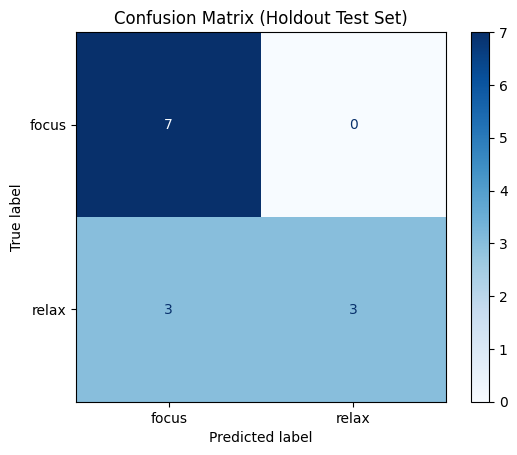

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score)
from scipy.stats import uniform

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])

param_dist = {
    'svc__C': uniform(0.1, 10),          # Regularization strength
    'svc__gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6)),  # Kernel coefficient
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],  # Different kernel types
    'svc__degree': [2, 3, 4],            # Only relevant if kernel='poly'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_trainval, y_trainval)

best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)
print("Training accuracy (CV avg): ", random_search.best_score_)

y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Holdout Test Set)")
plt.show()